# Project 1 

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy
import turbo
from mpl_toolkits.mplot3d import Axes3D  # NOQA: F401 unused import
from resources import franke
import fysstatistics as statistics

<IPython.core.display.Javascript object>


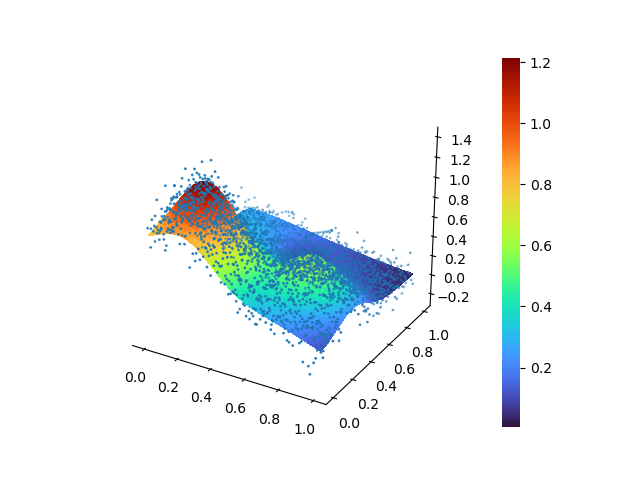

In [48]:
# Truth
x = np.linspace(0, 1)
y = np.linspace(0, 1)
X_true, Y_true = np.meshgrid(x, y)
Z_true = franke(X_true, Y_true)

# Noisy data
x_noise = np.linspace(0, 1, 50)
y_noise = np.linspace(0, 1, 50)
X_noise, Y_noise = np.meshgrid(x, y)
Z_noise = franke(X_noise, Y_noise)
Z_noise += np.random.normal(0, 0.1, Z_noise.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surface = ax.plot_surface(X_true, Y_true, Z_true, cmap='turbo', antialiased=False, linewidth=0)
ax.scatter(X_noise, Y_noise, Z_noise, s=1)
remove_panes(ax)
cb = fig.colorbar(surface)
cb.outline.set_linewidth(0)

## Performing linear regression

The Franke function is a function of two variables, so we need to use a bit more complicated regression. The Vandermonde should contain $n + m + 1$ variables where the constants are combined into one, or more generally $1+\Sigma_{i=1}^{i\le k}n_i$ for $k$ variables of order $n_i$. 

<IPython.core.display.Javascript object>


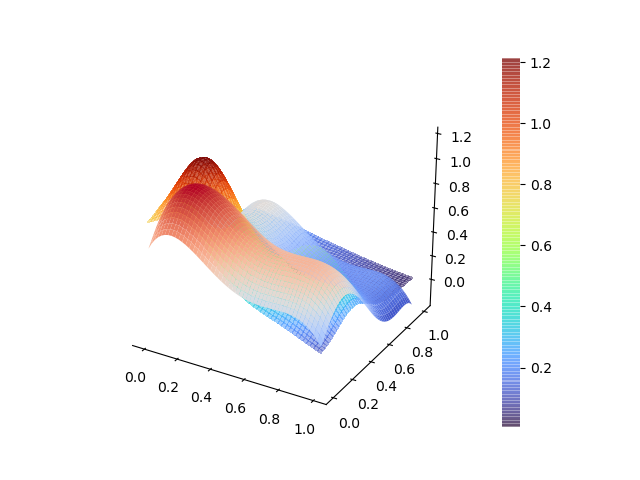

[[ -1.46093082   2.57287109]
 [  0.62703631   4.66083822]
 [-15.52655373 -11.49275181]
 [ 17.98153035  22.01533227]
 [-11.6726486   -7.63884668]
 [ -1.89249391   2.14130801]
 [ -0.4090858    3.62471611]
 [ -0.39726893   3.63653299]
 [-27.07371625 -23.03991434]
 [ 36.5347522   40.56855412]
 [-19.09348982 -15.05968791]]
[27.17054295  8.65067375 -6.95407929  4.01468619 -1.75143688  0.05670781
  5.26059546  0.83370385 -5.03015705  6.99280775 -7.78393198]


In [50]:
fitter = statistics.Regressor([X_noise, Y_noise], Z_noise)
fitter.fit([5, 5])
ẑ = fitter.predict([X_noise, Y_noise])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surface = ax.plot_surface(X_true, Y_true, Z_true, cmap='turbo', 
                          antialiased=False, linewidth=0, alpha=0.5)
ax.plot_surface(X_noise, Y_noise, ẑ, cmap='coolwarm')
remove_panes(ax)
cb = fig.colorbar(surface)
cb.outline.set_linewidth(0)
print(fitter.ci(0.95))
print(fitter.zscore)

## Todo

- [ ] Show how bias-variance changes as the order changes for many ensembles.
- [ ] Make confidence intervals.
  - Something is wrong
- [ ] Implement k-fold cross validation.
- [ ] Implement Lasso and Ridge regression by subclassing.
- [ ] Look at how the geo-data is structured.
- [x] Write tests

## Testing of the code

<IPython.core.display.Javascript object>


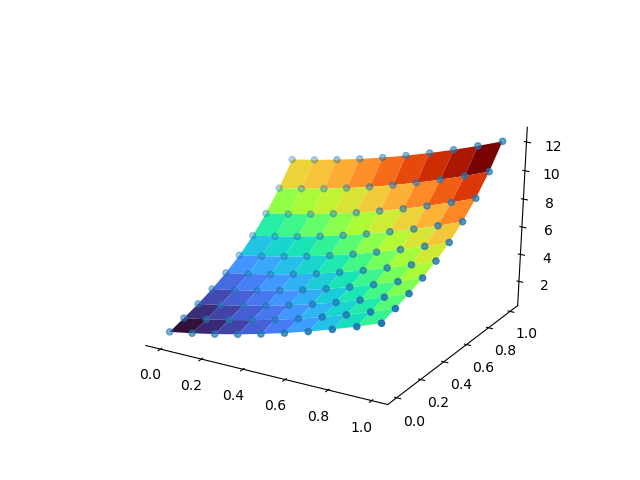

array([[ 1.00000000e+00,  1.00000000e+00],
       [ 2.50000000e+00,  2.50000000e+00],
       [ 1.70000000e+00,  1.70000000e+00],
       [-2.55935636e-14,  3.98044183e-14],
       [ 3.00000000e+00,  3.00000000e+00],
       [-4.45003962e-14,  5.51585372e-14],
       [ 4.00000000e+00,  4.00000000e+00]])

In [71]:
x, y = np.linspace(0, 1, 10), np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)
f = lambda x, y: 1 + 2.5*x + 1.7*x**2 + 3*y + 4*y**3
Z = f(X, Y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='turbo')
remove_panes(ax)

reg = statistics.Regressor([X, Y], Z)
reg.fit([3, 3])
Ẑ = reg.predict([X, Y])
ax.scatter(X, Y, Ẑ)

reg.ci(0.85)

In [4]:
def remove_panes(ax):
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [72]:
df = pd.DataFrame(data=fitter.vandermonde, columns=['constant', 'x1', 'x2', 'x3', 'x4', 'x5',
                                                    'y1', 'y2', 'y3', 'y4', 'y5'])
df['response'] = fitter.response

In [73]:
res = smf.ols("response ~ x1 + x2 + x3 + x4 + x5 + y1 + y2 + y3 + y4 + y5", data=df).fit()

In [74]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     871.2
Date:                Sun, 01 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:19:01   Log-Likelihood:                 1310.5
No. Observations:                2500   AIC:                            -2599.
Df Residuals:                    2489   BIC:                            -2535.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5560      0.020     27.176      0.000       0.516       0.596
x1             2.6439      0.306      8.652      0.000       2.045       3.243
x2           -13.5097      1.942     -6.955      0.000     -17.318      -9.701
x3            19.9984      4.980      4.015      0.000      10.232      29.764
x4            -9.6557      5.512     -1.752      0.080     -20.464       1.153
x5             0.1244      2.193      0.057      0.955      -4.177       4.425
y1             1.6078      0.306      5.262      0.000       1.009       2.207
y2             1.6196      1.942      0.834      0.404      -2.189       5.428
y3           -25.0568      4.980     -5.031      0.000     -34.823     -15.291
y4            38.5517      5.512      6.994      0.000      27.743      49.360
y5           -17.0766      2.193     -7.785      0.000     -21.378     -12.776
==============================================================================
Omnibus:                        2.097   Durbin-Watson:                   0.977
Prob(Omnibus):                  0.350   Jarque-Bera (JB):                2.149
Skew:                           0.066   Prob(JB):                        0.341
Kurtosis:                       2.943   Cond. No.                     4.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [113]:
print(fitter.β)
print(fitter.SSE)
print(fitter.var)
print(fitter.tscore)
fitter.ci(0.95)

[  0.55597013   2.64393726 -13.50965277  19.99843131  -9.65574764
   0.12440705   1.60781516   1.61963203 -25.05681529  38.55165316
 -17.07658887]
51.30401549656036
[4.18534990e-04 9.33744171e-02 3.77254629e+00 2.48035665e+01
 3.03814372e+01 4.81093689e+00 9.33744171e-02 3.77254629e+00
 2.48035665e+01 3.03814372e+01 4.81093690e+00]
[27.17600271  8.65241206 -6.95547667  4.01549292 -1.75178882  0.05671921
  5.26165255  0.83387138 -5.03116783  6.99421292 -7.78549612]


array([[  0.51585343,   0.59608684],
       [  2.04473522,   3.2431393 ],
       [-17.31835149,  -9.70095405],
       [ 10.23243854,  29.76442408],
       [-20.46419941,   1.15270412],
       [ -4.17663969,   4.42545379],
       [  1.00861312,   2.2070172 ],
       [ -2.18906669,   5.42833075],
       [-34.82280806, -15.29082253],
       [ 27.74320139,  49.36010493],
       [-21.3776356 , -12.77554213]])

In [100]:
print(res.bse)
print(fitter.var)

Intercept    0.020458
x1           0.305572
x2           1.942304
x3           4.980318
x4           5.511936
x5           2.193385
y1           0.305572
y2           1.942304
y3           4.980318
y4           5.511936
y5           2.193385
dtype: float64
[4.18703211e-04 9.34119470e-02 3.77406258e+00 2.48135358e+01
 3.03936484e+01 4.81287055e+00 9.34119470e-02 3.77406259e+00
 2.48135358e+01 3.03936484e+01 4.81287055e+00]


In [105]:
fitter.mse()

0.020521606198624143

In [107]:
fitter.sigma

0.020620585006656093